In [2]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interactive, IntProgress
from IPython.display import display

# Append base directory
import os,sys,inspect
rootname = "chernysheva-tmaze-analysis-2020"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

# Mesostat libraries
import mesostat.utils.pandas_helper as pandas_helper
from mesostat.utils.qt_helper import gui_fnames, gui_fpath
from mesostat.utils.plotting import stacked_bar_plot
from mesostat.metric.metric import MetricCalculator
from mesostat.metric.metric_non_uniform import MetricCalculatorNonUniform

# Local libraries
from src.lib.data_db import BehaviouralNeuronalDatabase

%load_ext autoreload
%autoreload 2

Appended root directory /home/alyosha/work/git/chernysheva-tmaze-analysis-2020


In [8]:
# tmp_path = root_path_data if 'root_path_data' in locals() else "./"
params = {}
#params['root_path_data']  = gui_fpath("Path to data files", "./")
params['root_path_dff'] = '/media/alyosha/Data/TE_data/mariadata/dff/'
params['root_path_deconv'] = '/media/alyosha/Data/TE_data/mariadata/deconv/'
# params['root_path_dff'] = '/home/alyosha/Desktop/maria/dff/'
# params['root_path_deconv'] = '/home/alyosha/Desktop/maria/deconv/'

# params['root_path_dff'] = '/media/aleksejs/DataHDD/work/data/maria/dff/'
# params['root_path_deconv'] = '/media/aleksejs/DataHDD/work/data/maria/deconv/'

In [9]:
dataDB = BehaviouralNeuronalDatabase(params)

In [10]:
dataDB.read_neuro_files()

IntProgress(value=0, description='Read DFF Data:', max=27)

IntProgress(value=0, description='Read DECONV Data:', max=27)

In [11]:
dataDB.read_behavior_files()

IntProgress(value=0, description='Read Neuro Data:', max=27)

No trials found for Trial_LWhole_Mistake skipping
No trials found for Trial_RWhole_Mistake skipping
No trials found for Trial_LWhole_Mistake skipping


# 1. Initial Exploration

## 1.1 Number of trials per mouse -> barplot

No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm067_20200203'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping


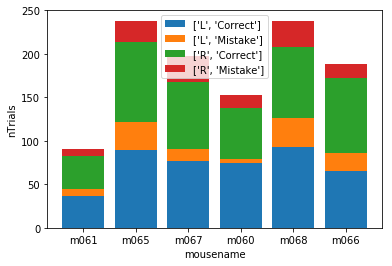

In [12]:
df = pd.DataFrame([], columns=["mousename", "performance", "direction", "nTrials"])

for mousename in dataDB.mice:
    for performance in ['Correct', 'Mistake']:
        for direction in ['L', 'R']:
            queryDict = {'mousename' : mousename, 'performance' : performance, 'direction' : direction}
            dataThis = dataDB.get_data_from_phase("Maintenance", queryDict)
            df = pandas_helper.add_list_as_row(df, [mousename, performance, direction, len(dataThis)])
            
df["nTrials"] = pd.to_numeric(df["nTrials"])

fig, ax = plt.subplots()
stacked_bar_plot(ax, df, 'mousename', 'nTrials')
plt.savefig('trial_distribution_by_mouse.pdf')
plt.show()

## 1.2 Number of timesteps per phase -> violinplot

/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


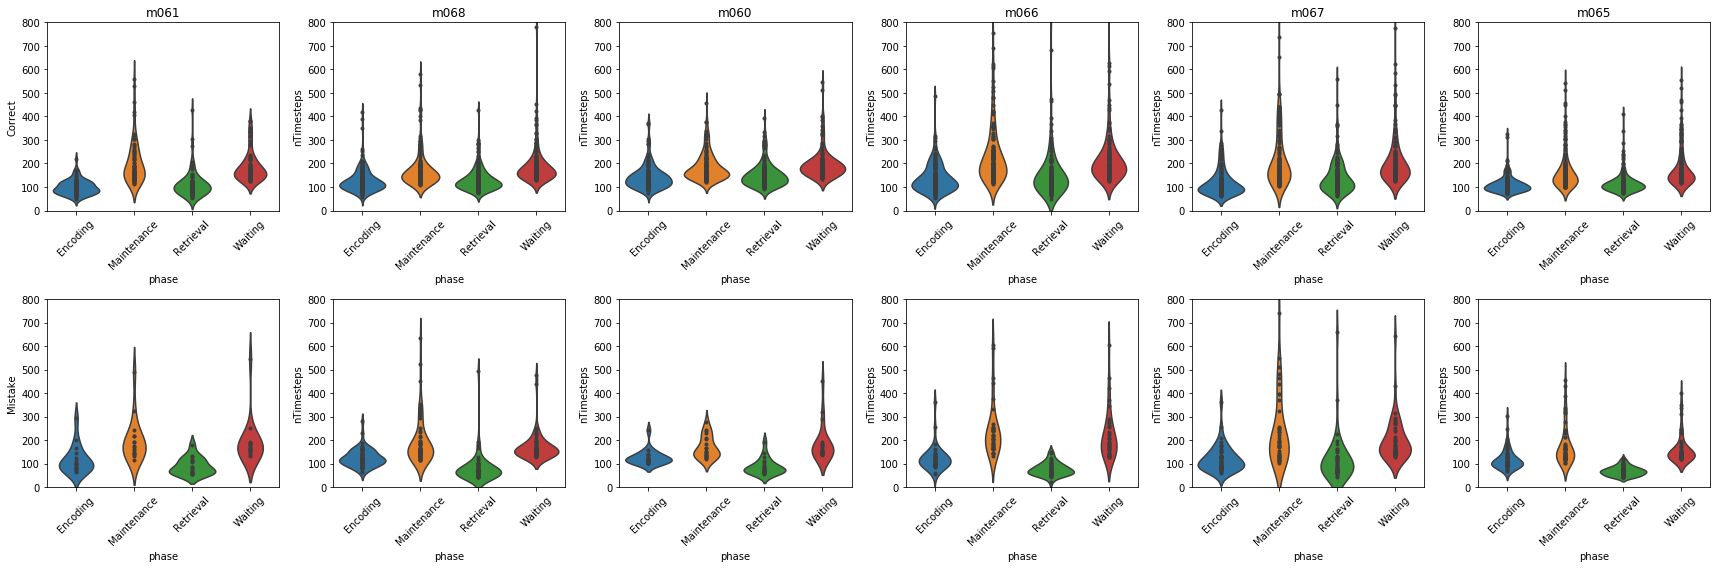

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=len(dataDB.mice), figsize=(4*len(dataDB.mice), 4*2), tight_layout=True)
for iMouse, mousename in enumerate(dataDB.mice):
    iRow = 0
    for performance in ['Correct', 'Mistake']:
        nStepLstLst = []

        df = pd.DataFrame([], columns=["phase", "nTimesteps"])

        for phase in dataDB.phases[performance]:
            queryDict = {'mousename' : mousename, 'performance' : performance}
            dataThis = dataDB.get_data_from_phase(phase, queryDict)
            for d in dataThis:
                df = pandas_helper.add_list_as_row(df, [phase, d.shape[1]], skip_repeat=False)

        df["nTimesteps"] = pd.to_numeric(df["nTimesteps"])

        plot1 = sns.violinplot(ax=ax[iRow, iMouse], x='phase', y='nTimesteps', data=df, inner="points")
        plot1.set_xticklabels(plot1.get_xticklabels(), rotation=45)
        ax[iRow, iMouse].set_ylim([0, 800])
        ax[iRow, 0].set_ylabel(performance)
        iRow += 1
            
    ax[0, iMouse].set_title(mousename)
                
plt.show()

## 1.3 Number of timesteps per interval -> violinplot  (Focus on Maintenance)

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


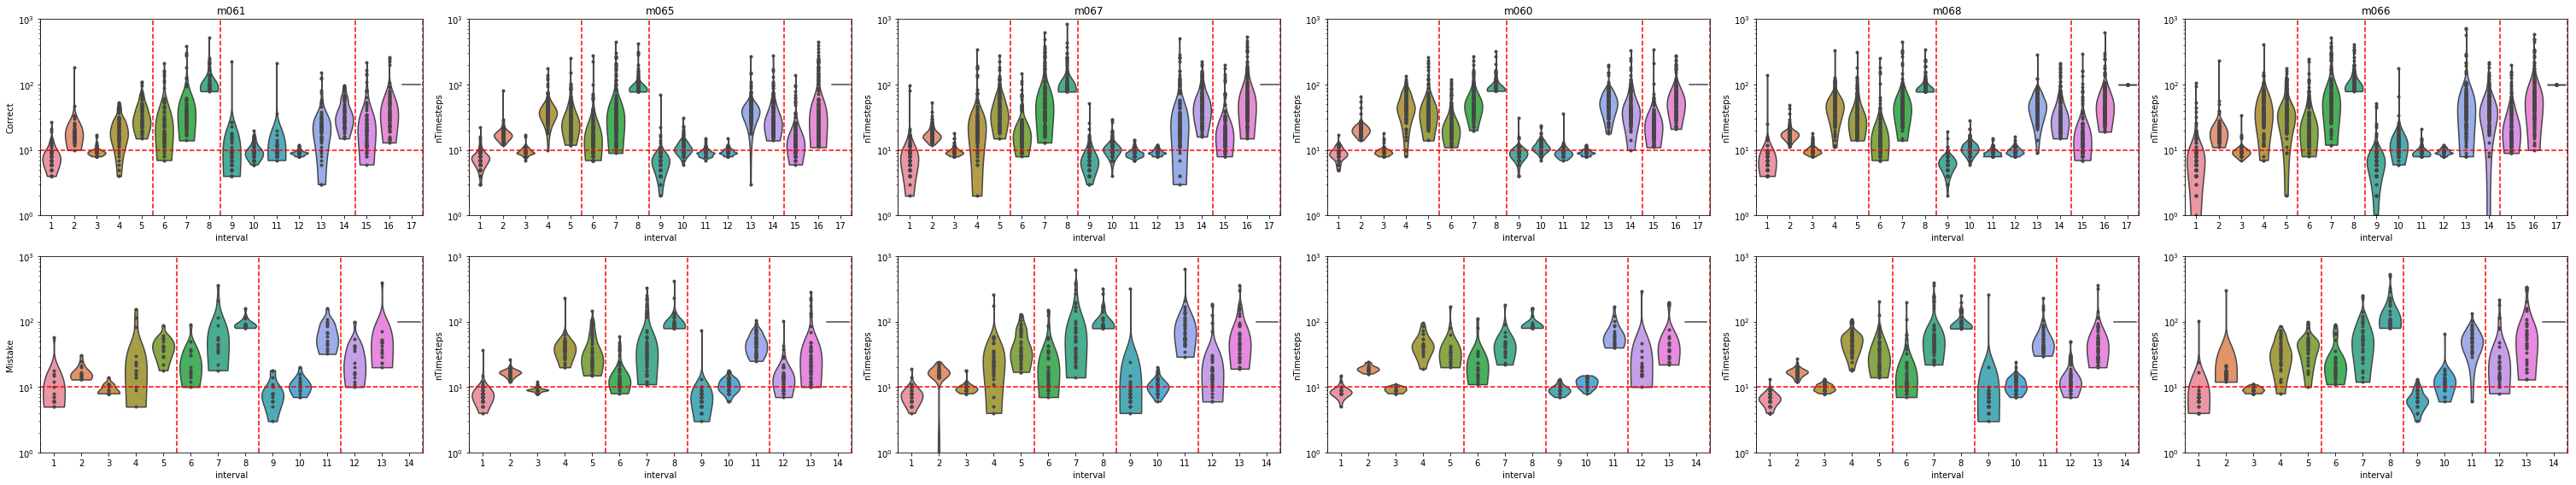

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=len(dataDB.mice), figsize=(7*len(dataDB.mice), 4*2), tight_layout=True)
for iMouse, mousename in enumerate(dataDB.mice):
    iRow = 0
    for performance in ['Correct', 'Mistake']:
        boundingLines = dataDB.get_phase_bounding_lines(performance)
        
        df = pd.DataFrame([], columns=["interval", "nTimesteps"])
        nIntervals = len(dataDB.metaDataFrames['interval_maps'][performance])
        for iInt in range(1, nIntervals):
            queryDict = {'mousename' : mousename, 'performance' : performance}
            dataThis = dataDB.get_data_from_interval(iInt-1, iInt, queryDict)
            for d in dataThis:
                df = pandas_helper.add_list_as_row(df, [iInt, d.shape[1]], skip_repeat=False)

        df["nTimesteps"] = pd.to_numeric(df["nTimesteps"])

        plot1 = sns.violinplot(ax=ax[iRow, iMouse], x='interval', y='nTimesteps', data=df, cut=0, scale="width", inner='points')
        ax[iRow, iMouse].set_ylim([1, 1000])
        ax[iRow, iMouse].set_yscale("log")
        ax[iRow, iMouse].axhline(y=10, linestyle='--', color='r')
        for bline in boundingLines:
            ax[iRow, iMouse].axvline(x=bline-0.5, linestyle='--', color='r')
        
        ax[iRow, 0].set_ylabel(performance)
        iRow += 1
            
    ax[0, iMouse].set_title(mousename)
                
plt.savefig('interval_duration_distribution.pdf')
plt.show()

# 2. SNR

**Goal**: Test temporal dynamics of CA kernel, see if there is clear noise in the data

doing mouse m060
doing mouse m061
doing mouse m065
doing mouse m066
doing mouse m067
doing mouse m068


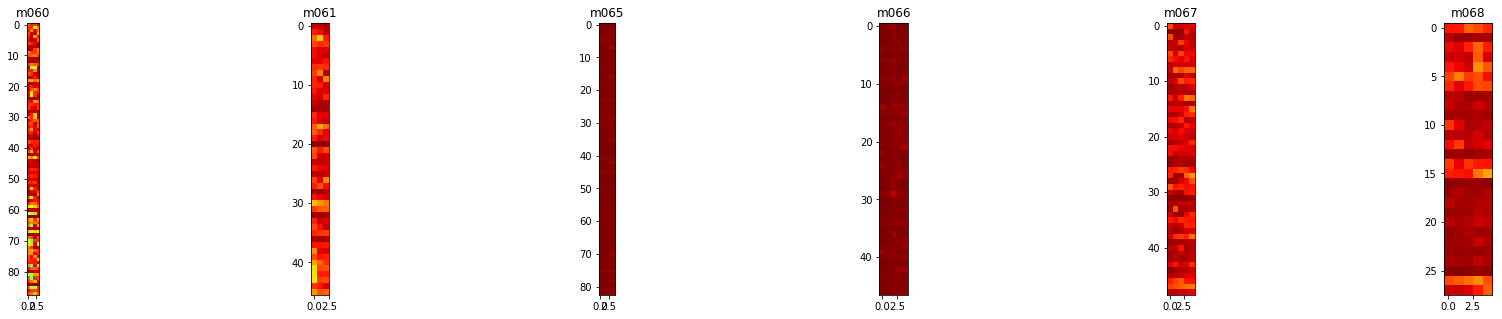

In [10]:
mc = MetricCalculator(serial=True, verbose=False)

fig, ax = plt.subplots(ncols=len(dataDB.mice), figsize=(5 * len(dataDB.mice),5))
for iMouse, mousename in enumerate(sorted(dataDB.mice)):
    print('doing mouse', mousename)
    rows = dataDB.get_rows('dff', {'mousename' : mousename})

    rez = []
    for idx, row in rows.iterrows():
        mc.set_data(dataDB.dataNeuronal['raw'][idx], 'sp')
        rez += [mc.metric3D('autocorr_d1', 'p', metricSettings=None, sweepSettings=None)]
        
    ax[iMouse].set_title(mousename)
    ax[iMouse].imshow(np.array(rez).T, cmap='jet', vmin=0, vmax=1)
plt.show()